# Viscosity

## Overview

The `polykin.properties.viscosity` module provides methods to estimate the viscosity of pure
gases, gas mixtures, and liquid mixtures.

|                       |                     Gas                    |        Liquid        |
|-----------------------|:------------------------------------------:|:--------------------:|
| Property equations    |                  `DIPPR102`                |  `DIPPR101`, `Yaws`  |
| Estimation methods    |            `MUV_Lucas`, `MUVMX_Lucas`      |           —          |
| Mixing rules          |               `MUVMX2_Herning`             |     `MULMX2_Perry`   |
| Pressure correction   |     `MUVPC_Jossi`, `MUVMXPC_Dean_Stiel`    |           —          |

## Pure gases

At low pressures, the viscosity of gases is independent of pressure and increases with temperature. 
Near the critical point, the behaviour is quite complex.

### Temperature correlations at low pressure

The viscosity of low-pressure gases increases with temperature. Experimental data is usually correlated with DIPPR-102. 

In [1]:
# %pip install polykin
from polykin.properties.equations import DIPPR102

Let us define correlations for the viscosity of ethylene, propylene and nitrogen.

In [2]:
# Parameters from literature
muv_ethylene  = DIPPR102(2.08e-6, 0.416, 353., 0, Tmin=169., Tmax=1000.,
                         symbol=r'\mu', unit='Pa·s', name='ethylene')
muv_propylene = DIPPR102(7.39E-07, 0.542, 263., 0, Tmin=88., Tmax=1000.,
                         symbol=r'\mu', unit='Pa·s', name='propylene')
muv_nitrogen  = DIPPR102(6.56E-07, 0.608, 54.7, 0, Tmin=63., Tmax=1970.,
                         symbol=r'\mu', unit='Pa·s', name='nitrogen')

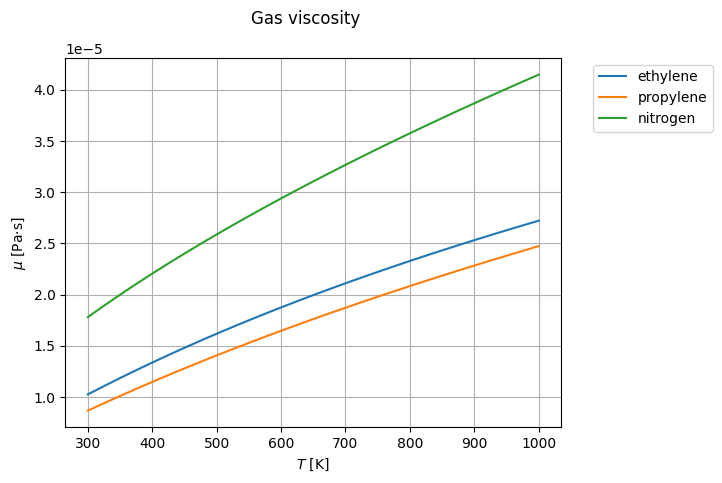

In [3]:
from polykin import plotequations

_ = plotequations([muv_ethylene, muv_propylene, muv_nitrogen],
                  title="Gas viscosity", Trange=(300, 1000))

### Estimation methods

The viscosity of pure gases can be estimated at any temperature and pressure with Lucas' method.

In [4]:
from polykin.properties.viscosity import MUV_Lucas

Let us estimate the viscosity of ethylene as a function of temperature and pressure.

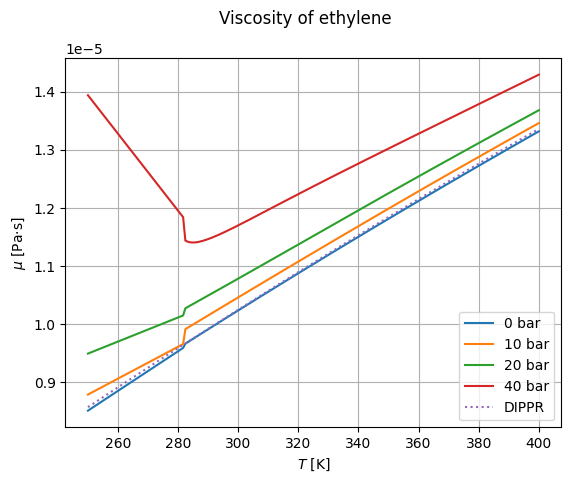

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Range of pressure and temperature
P = [0, 10e5, 20e5, 40e5]          # Pa
T = np.linspace(250.0, 400.0, 200) # K

# Ethylene constants
M = 28.05e-3 # kg/mol
Tc = 282.4   # K
Pc = 50.4e5  # Pa
Zc = 0.280
dm = 0.0     # debye

# Plot estimated values
fig, ax = plt.subplots()
fig.suptitle("Viscosity of ethylene")
for p in P:
    MU = []
    for t in T:
        mu = MUV_Lucas(t, p, M, Tc, Pc, Zc, dm)
        MU.append(mu)
    ax.plot(T, MU, label=fr"{p/1e5:.0f} bar")

# Overlay DIPPR correlation
ax.plot(T, muv_ethylene(T), linestyle=':', label="DIPPR")

ax.set_xlabel(r"$T$ [K]")
ax.set_ylabel(r"$\mu$ [Pa·s]")
ax.legend(loc="lower right")
ax.grid(True)

Note the excellent agreement between the low-pressure estimates and the DIPPR correlation (based on experimental data).

### Pressure correction

The increase of viscosity with respect to the low-pressure value can be estimated with the method of Jossi, Stiel and Thodos. The primary argument of this method is the reduced density, which can be estimated with an equation of state, like `PengRobinson`.

In [6]:
from polykin.properties.viscosity import MUVPC_Jossi
from polykin.thermo.eos import PengRobinson

Let us estimate the residual viscosity of ethylene at 350 K and 40 bar.

In [7]:
# Compressibility factor
eos = PengRobinson(Tc, Pc, w=0.089)
T = 350.0 # K
P = 40e5  # Pa
Z = eos.Z(T, P, np.array([1.0]))[0]

# Reduced density
rhor = (Zc/Z)*(Tc/T)*(P/Pc)
rhor

np.float64(0.21372115947337894)

In [8]:
MUVPC_Jossi(rhor, M, Tc, Pc)

np.float64(1.2369895119543625e-06)

The value so obtained is very close to the one obtained with Lucas' method.

In [9]:
MUV_Lucas(T, P, M, Tc, Pc, Zc, dm) - MUV_Lucas(T, 0, M, Tc, Pc, Zc, dm)

np.float64(1.2072145377380983e-06)

## Gas mixtures

### Estimation methods

The viscosity of gas mixtures can be estimated at any temperature and pressure with Lucas' method for mixtures.

In [10]:
from polykin.properties.viscosity import MUVMX_Lucas

Let us estimate the viscosity of a 50 mol% ethylene/nitrogen gas mixture as a function of temperature and pressure.

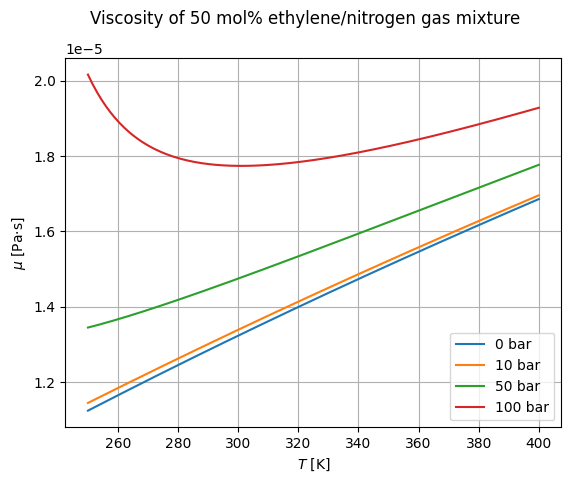

In [11]:
# Range of pressure and temperature
P = [0, 10e5, 50e5, 100e5]         # Pa
T = np.linspace(250.0, 400.0, 200) # K

# Mixture composition
y = [0.5, 0.5]         # mol/mol

# [ethylene, N₂] constants
M = [28e-3, 28e-3]     # kg/mol
Tc = [282.4, 126.2]    # K
Pc = [50.4e5, 33.9e5]  # Pa
Zc = [0.280, 0.290]
dm = [0. , 0. ]        # debye

# Plot
fig, ax = plt.subplots()
fig.suptitle("Viscosity of 50 mol% ethylene/nitrogen gas mixture")
for p in P:
    MU = []
    for t in T:
        mu = MUVMX_Lucas(t, p, y, M, Tc, Pc, Zc, dm)
        MU.append(mu)
    ax.plot(T, MU, label=fr"{p/1e5:.0f} bar")
ax.set_xlabel(r"$T$ [K]")
ax.set_ylabel(r"$\mu$ [Pa·s]")
ax.legend(loc="lower right")
ax.grid(True)

### Mixing rules at low pressure

The viscosity of low-pressure gas mixtures can be estimated from the corresponding pure-component values using the mixing rule of Herning and Zipperer.

In [12]:
from polykin.properties.viscosity import MUVMX2_Herning_Zipperer

Let us estimate the viscosity of a 50 mol% ethylene/nitrogen gas mixture at 350 K and 0 bar.

In [13]:
T = 350.0 # K
mu = [muv_ethylene(T), muv_nitrogen(T)]  # pure muv(T), Pa.s 

In [14]:
MUVMX2_Herning_Zipperer(y=[0.5, 0.5], mu=mu, M=M)

np.float64(1.591297700896268e-05)

This value compares quite favorably with the one obtained with Lucas' method.

### Pressure correction

The increase of viscosity with respect to the low-pressure value can be estimated with the method of Dean and Stiel. The primary argument of this method is the molar volume, which can be estimated with an equation of state.

In [15]:
from polykin.properties.viscosity import MUVMXPC_Dean_Stiel

Let us estimate the residual viscosity of a 50 mol% ethylene/nitrogen gas mixture at 350 K and 100 bar.

In [16]:
y = [0.5, 0.5] # mol/mol
v = 2.6e-4     # m³/mol, @ 350K, 100 bar, 50% using Peng-Robinson

MUVMXPC_Dean_Stiel(v, y, M, Tc, Pc, Zc)

np.float64(3.0279766326342337e-06)

Again, this value compares quite favorably with the one obtained with Lucas' method.

## Pure liquids

### Temperature correlations

The viscosity decreases with temperature. Experimental data is usually correlated with DIPPR-101 or Yaws' equation. 

In [17]:
from polykin.properties.equations import Yaws

Let us define correlations for the viscosity of styrene and butadiene.

In [18]:
# Parameters from Reid, Prausnitz, Pooling (1988)
mul_styrene = Yaws(A=-2.717, B=9.461e2, C=-3.173e-3, D=1.683e-6, base10=False,
                   Tmin=243., Tmax=633., unit='cP', name='styrene')
mul_butadiene = Yaws(A=-6.072, B=1.000e3, C=4.46e-3, D=-6.694e-6, base10=False,
                   Tmin=165., Tmax=425., unit='cP', name='1,3-butadiene')

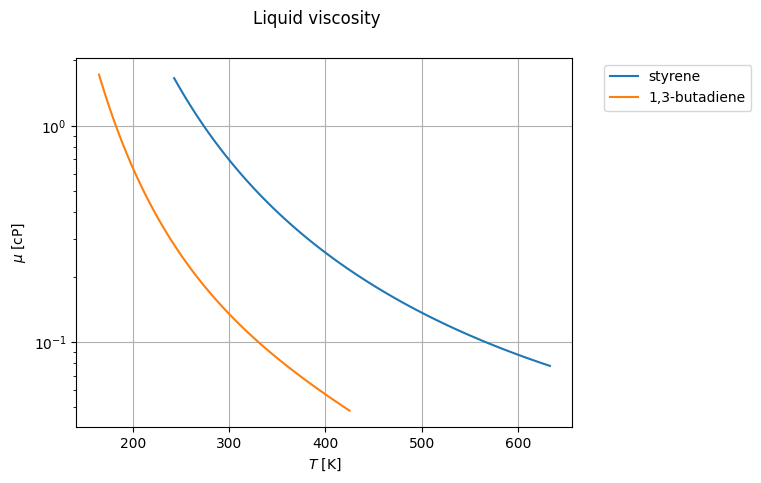

In [19]:
_ = plotequations([mul_styrene, mul_butadiene], kind='semilogy',
                  title="Liquid viscosity")

## Liquid mixtures

### Mixing rules

The viscosity of (non-polymeric) liquid mixtures can be estimated from the corresponding pure-component values using generic mixing rules recommended in Perry's.

In [20]:
from polykin.properties.viscosity import MULMX2_Perry

Let us estimate de viscosity of a 50 mol% mixture of styrene and butadiene at 350 K.

In [21]:
T = 350.0 # K
mu = [mul_styrene(T), mul_butadiene(T)] # pure mul(T), cP

In [22]:
MULMX2_Perry(x=[0.5, 0.5], mu=mu)

np.float64(0.1834054702254802)